In [ ]:
## TODO
## subclass nx.graph and store adj, D, etc as attribute variables
## Grabriel quality

In [1]:
## custom
from utils import utils, vis
from utils import poly_point_isect as bo   ##bentley-ottmann sweep line
import criteria as C
import quality as Q
import gd2


## third party
import networkx as nx

from PIL import Image
from natsort import natsorted


## sys
import random
import time
from glob import glob
import math
from collections import defaultdict
import os
from pathlib import Path


## numeric
import numpy as np
import scipy.io as io
import torch
from torch import nn, optim
import torch.nn.functional as F


## vis
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits import mplot3d
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d.art3d import Line3DCollection

## notebook
from IPython import display
from IPython.display import clear_output
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')


## Optimize via Stochastic Gradient Descent (SGD)

In [2]:
# delete old
# !rm -r figures
# !mkdir figures

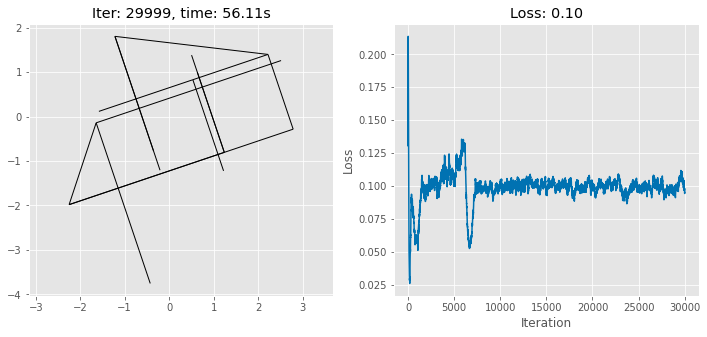

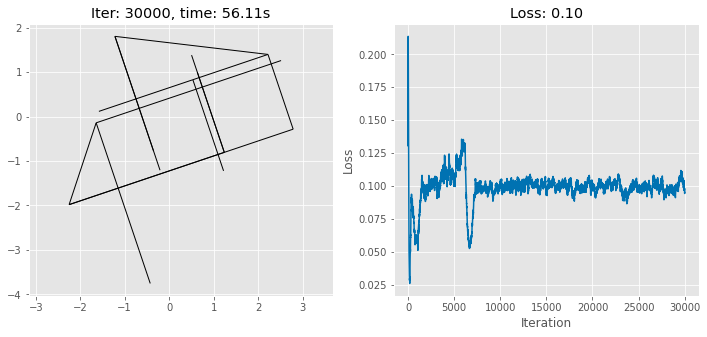

CPU times: user 1min, sys: 945 ms, total: 1min 1s
Wall time: 59.4 s


In [56]:
%%time


import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2
importlib.reload(gd2)
from gd2 import GD2


##choose a graph
G = nx.balanced_tree(2,3)
# G = nx.grid_2d_graph(15,10)
# G = nx.hypercube_graph(4)
# G = utils.load_spx_teaser()
# G = nx.karate_club_graph()

# graph_name = 'grid1'
# graph_name = 'grid1_dual'
# graph_name = 'odepa400'
# graph_name = 'netz4504_dual'
# graph_name = 'L'
# -----
# graph_name = 'netz4504'
# graph_name = 'qh882'
# mat_dir = 'graphs/SuiteSparse Matrix Collection'
# G = utils.load_mat(f'{mat_dir}/{graph_name}.mat')


# G = nx.Graph()
# G.add_nodes_from([0,1,2,3])
# G.add_edges_from([(0,1),(2,3)])




## choose criteria

criteria_pair = {'stress', 'crossing_angle_maximization'}



criteria_weights = dict(
    stress=0.0,
    edge_uniformity=0.005,
    neighborhood_preservation=0.5,
    crossings=1,
    crossing_angle_maximization=0.1,
    aspect_ratio=10,
    angular_resolution=0.01,
    vertex_resolution=0.05,
    gabriel=0.01,
)

sample_sizes = dict(
    stress=64,
    edge_uniformity=int(len(G)**0.5),
    neighborhood_preservation=16,
    crossings=16,
    crossing_angle_maximization=10,
    aspect_ratio=int(len(G)**0.5),
    angular_resolution=32,
    vertex_resolution=int(len(G)**0.5),
#     vertex_resolution=len(G),
    gabriel=10,
)

gd = GD2(G)

result = gd.optimize(
    criteria_weights={c:criteria_weights[c] for c in criteria_pair}, 
    sample_sizes=sample_sizes,
    
#     evaluate='all',
#     evaluate={'stress'},    
#     evaluate={'angular_resolution'},
#     evaluate={'neighborhood_preservation'},
#     evaluate={'crossing_angle_maximization'},
    evaluate=criteria_pair,
    
    max_iter=30000, 
    evaluate_interval=30000//40,
    vis_interval=30000//10,
    clear_output=True,
    
    optimizer_kwargs = dict(lr=2),
    scheduler_kwargs = dict(verbose=True),
)

pos = gd.pos.detach().numpy()
pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
vis.plot(
    gd.G, pos_G,
    gd.loss_curve, 
    result['iter'], result['runtime'],
    edge=True, show=True, save=False
)



Text(0, 0.5, 'crossing_angle_maximization')

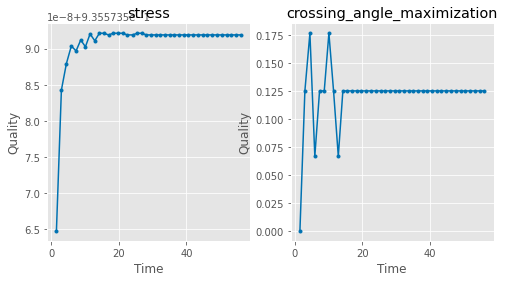

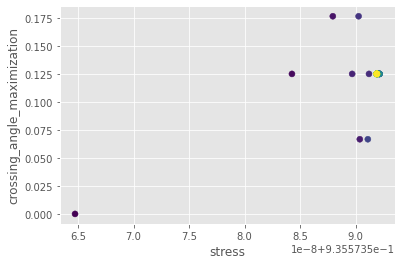

In [58]:
qx, qy = criteria_pair

t = [r['time'] for r in gd.qualities_by_time]
quality_curve_x = [r['qualities'][qx] for r in gd.qualities_by_time]
quality_curve_y = [r['qualities'][qy] for r in gd.qualities_by_time]

plt.figure(figsize=[8,4])
plt.subplot(121)
plt.plot(t, quality_curve_x, '.-')
plt.title(qx)
plt.xlabel('Time')
plt.ylabel('Quality')

plt.subplot(122)
plt.plot(t, quality_curve_y, '.-')
plt.title(qy)
plt.xlabel('Time')
plt.ylabel('Quality')

plt.figure()
# plt.plot(quality_curve_x, quality_curve_y, '--', c='#777777', zorder=-1)
plt.scatter(quality_curve_x, quality_curve_y, c=np.arange(len(quality_curve_x)))
plt.xlabel(qx)
plt.ylabel(qy)
# plt.xlim([0, max(max(quality_curve_x), 1.1)])
# plt.ylim([0, max(max(quality_curve_y)*1.05, 1.1)])


## Example matrix

In [84]:
# !mkdir -p ./analysis/pairs

In [39]:
##todo move it to GD2.py

import pickle as pkl

def dump(gd, fn='result.pkl'):
    with open(fn, 'wb') as f:
        pkl.dump(dict(
            G=gd.G,
            pos=gd.pos,
            i2k=gd.i2k,
            k2i=gd.k2i,
            iter=gd.i,
            runtime=gd.runtime,
            loss_curve=gd.loss_curve,
            qualities_by_time = gd.qualities_by_time,
        ), f)

In [ ]:
##choose a graph
G = nx.balanced_tree(2,5)
graph_str = 'tree_2_5'

# G = nx.grid_2d_graph(15,10)
# graph_str = 'grid_15_10'

start_date = int(time.time())
dir_out = f'./analysis/criteria_pairs/{graph_str}-t{start_date}'
print(dir_out)
if not Path(dir_out).exists():
    os.makedirs(dir_out)

./analysis/criteria_pairs/tree_2_5-t1633984153
{'stress'}



{'stress': 0.058618379758357445, 'edge_uniformity': 0.006538372952491045, 'neighborhood_preservation': 0.5497075915336609, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.1626184582710266, 'angular_resolution': 0.6992974877357483, 'vertex_resolution': 0.4959751901700272, 'gabriel': 4.172325134277344e-07}


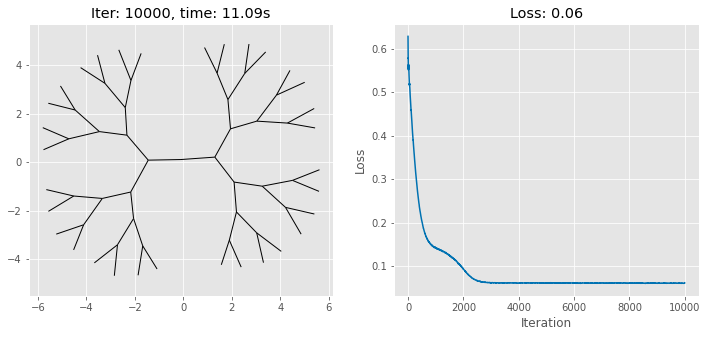

{'edge_uniformity', 'stress'}



{'stress': 0.059078107700486215, 'edge_uniformity': 0.009806306101381779, 'neighborhood_preservation': 0.5497075915336609, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.17007070779800415, 'angular_resolution': 0.6682423055171967, 'vertex_resolution': 0.4663959359561861, 'gabriel': 4.172325134277344e-07}


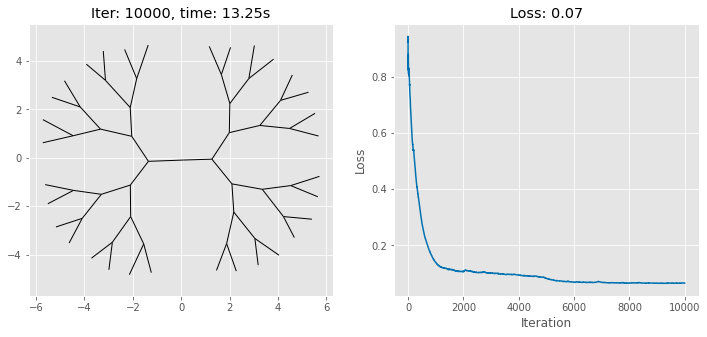

{'neighborhood_preservation', 'stress'}



{'stress': 0.10610904951751639, 'edge_uniformity': 0.28304344415664673, 'neighborhood_preservation': 0.2657342553138733, 'crossings': 2, 'crossing_angle_maximization': 0.013515198874667343, 'aspect_ratio': 0.36066901683807373, 'angular_resolution': 0.8985864892601967, 'vertex_resolution': 0.8713401536501955, 'gabriel': 0.35375797748565674}


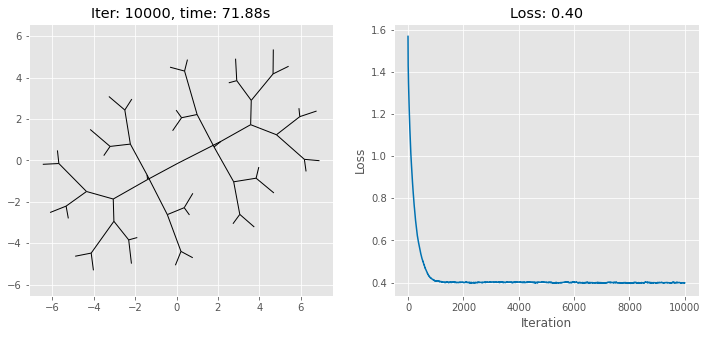

{'stress', 'crossings'}



{'stress': 0.07031131220894345, 'edge_uniformity': 0.012140974402427673, 'neighborhood_preservation': 0.5497075915336609, 'crossings': 1, 'crossing_angle_maximization': 0.00257999012248615, 'aspect_ratio': 0.2264196276664734, 'angular_resolution': 0.7612483501434326, 'vertex_resolution': 0.4997266462137884, 'gabriel': 0.5097651779651642}


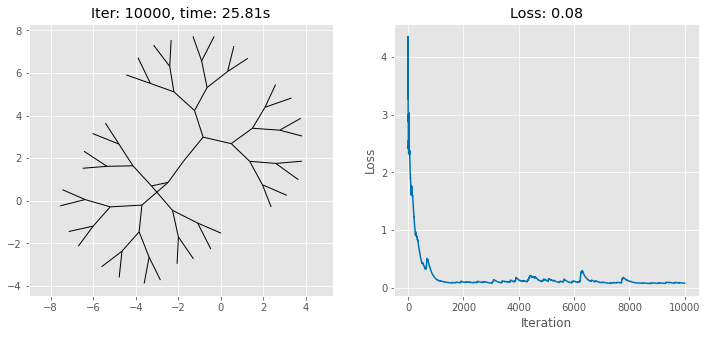

{'stress', 'crossing_angle_maximization'}



{'stress': 0.07233649928609558, 'edge_uniformity': 0.027488011866807938, 'neighborhood_preservation': 0.6067415773868561, 'crossings': 6, 'crossing_angle_maximization': 0.04557785233149509, 'aspect_ratio': 0.21826326847076416, 'angular_resolution': 0.9989521921379492, 'vertex_resolution': 0.7359740264556835, 'gabriel': 0.7343036234378815}


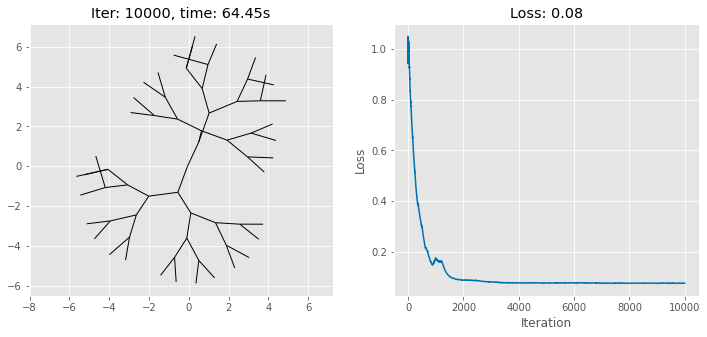

{'stress', 'aspect_ratio'}



{'stress': 0.0759861419302876, 'edge_uniformity': 0.1334322690963745, 'neighborhood_preservation': 0.5411764681339264, 'crossings': 1, 'crossing_angle_maximization': 0.3917324465956675, 'aspect_ratio': 0.053143858909606934, 'angular_resolution': 0.9143427163362503, 'vertex_resolution': 0.932486818576394, 'gabriel': 0.8207012116909027}


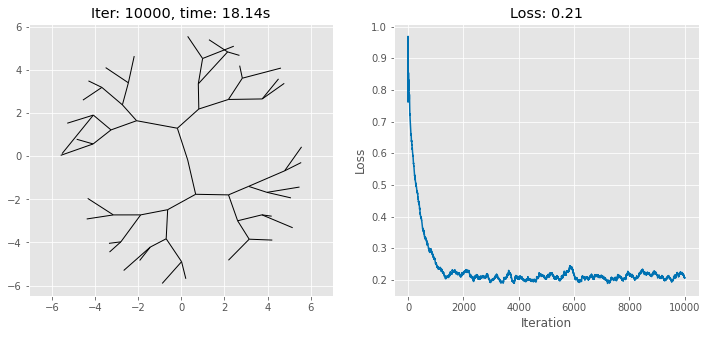

{'stress', 'angular_resolution'}



{'stress': 0.06317590044467238, 'edge_uniformity': 0.03036513738334179, 'neighborhood_preservation': 0.44999998807907104, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.1710125207901001, 'angular_resolution': 0.4301968216896057, 'vertex_resolution': 0.8474151297337703, 'gabriel': 0.7786536365747452}


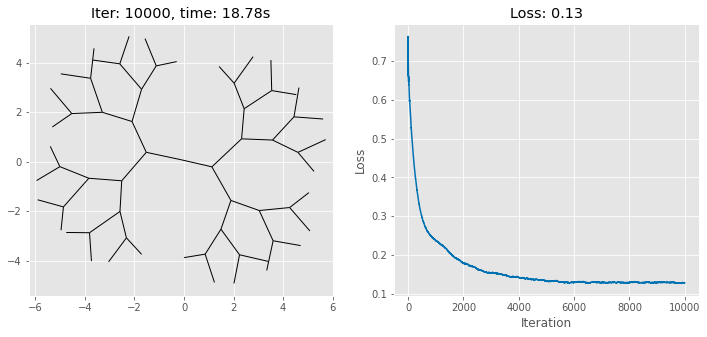

{'stress', 'vertex_resolution'}



{'stress': 0.07025095582240114, 'edge_uniformity': 0.019281407818198204, 'neighborhood_preservation': 0.5664739906787872, 'crossings': 1, 'crossing_angle_maximization': 0.07135870491767132, 'aspect_ratio': 0.20934772491455078, 'angular_resolution': 0.9167781323194504, 'vertex_resolution': 0.6979177425513035, 'gabriel': 0.5466784536838531}


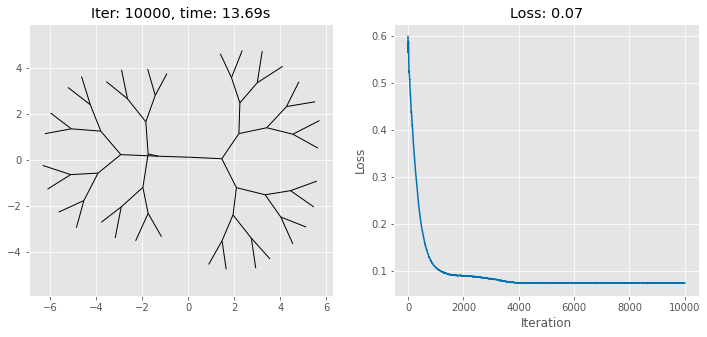

{'gabriel', 'stress'}



{'stress': 103.84105253801513, 'edge_uniformity': 138.85496520996094, 'neighborhood_preservation': 0.8828828856348991, 'crossings': 29, 'crossing_angle_maximization': 0.7440011226408723, 'aspect_ratio': 0.13152146339416504, 'angular_resolution': 0.9960317742079496, 'vertex_resolution': 0.9185919550148075, 'gabriel': 0.8466415405273438}


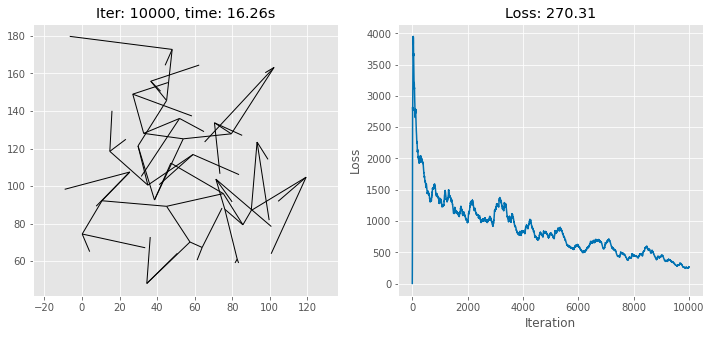

{'edge_uniformity'}



{'stress': 0.5429077501545452, 'edge_uniformity': 5.707638680262084e-14, 'neighborhood_preservation': 1.0, 'crossings': 551, 'crossing_angle_maximization': 0.9847379701271417, 'aspect_ratio': 0.23702633380889893, 'angular_resolution': 0.9879276128485799, 'vertex_resolution': 0.9467064141755088, 'gabriel': 0.9546871557831764}


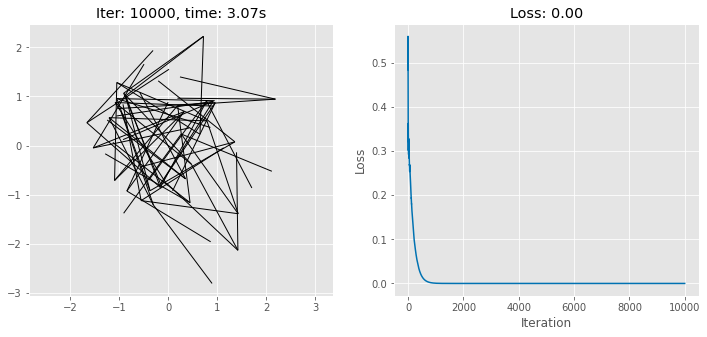

{'neighborhood_preservation', 'edge_uniformity'}



{'stress': 0.0843146044747342, 'edge_uniformity': 0.10349105298519135, 'neighborhood_preservation': 0.2535211443901062, 'crossings': 1, 'crossing_angle_maximization': 0.17425360748914398, 'aspect_ratio': 0.21186822652816772, 'angular_resolution': 0.7412190437316895, 'vertex_resolution': 0.6624388118854903, 'gabriel': 0.42825406789779663}


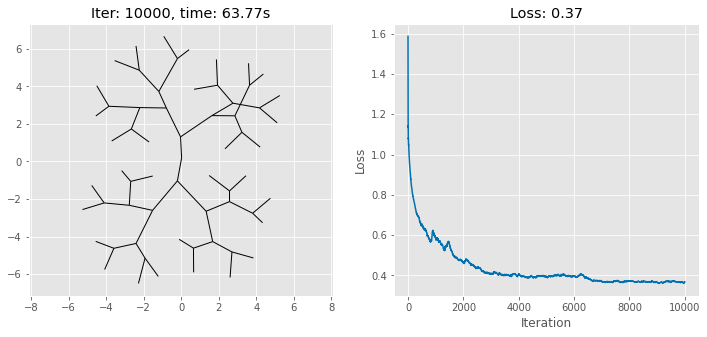

{'edge_uniformity', 'crossings'}



{'stress': 2.73869532248361, 'edge_uniformity': 0.8950738310813904, 'neighborhood_preservation': 0.8977777808904648, 'crossings': 6, 'crossing_angle_maximization': 0.582503462609158, 'aspect_ratio': 0.16659069061279297, 'angular_resolution': 0.9841226562857628, 'vertex_resolution': 0.9098338280821844, 'gabriel': 0.6490539908409119}


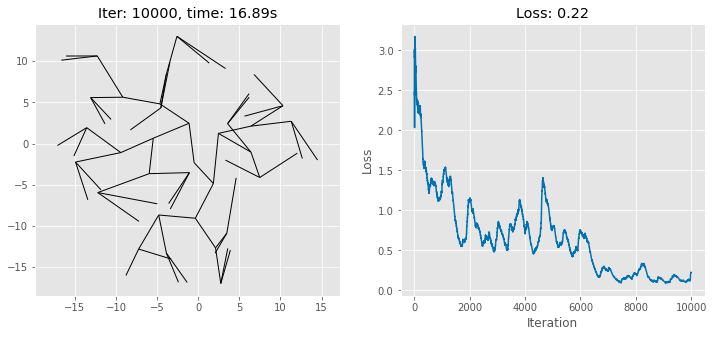

{'edge_uniformity', 'crossing_angle_maximization'}



{'stress': 0.66993564806295, 'edge_uniformity': 0.0001777590805431828, 'neighborhood_preservation': 1.0, 'crossings': 322, 'crossing_angle_maximization': 0.9988792696757268, 'aspect_ratio': 0.2870432734489441, 'angular_resolution': 0.9998935628900654, 'vertex_resolution': 0.9929851161452803, 'gabriel': 0.25364482402801514}


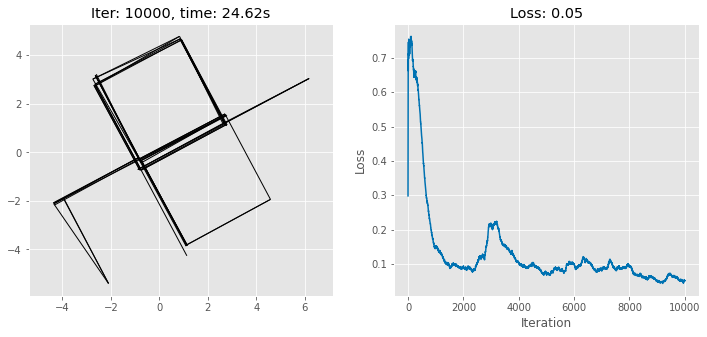

{'edge_uniformity', 'aspect_ratio'}



{'stress': 10.861314012079859, 'edge_uniformity': 0.017809320241212845, 'neighborhood_preservation': 1.0, 'crossings': 453, 'crossing_angle_maximization': 0.973530236827077, 'aspect_ratio': 0.08480912446975708, 'angular_resolution': 0.9995895056345034, 'vertex_resolution': 0.9960440899055549, 'gabriel': 0.9466738924384117}


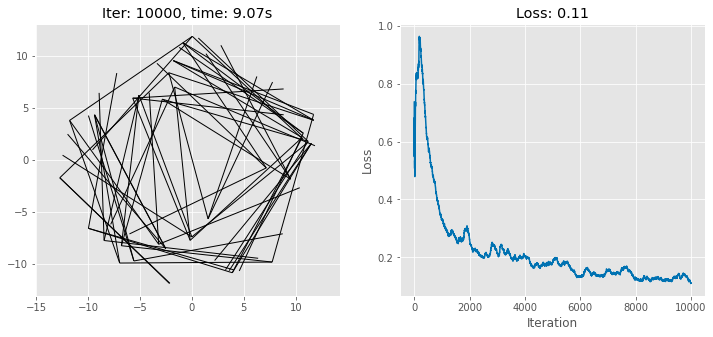

{'edge_uniformity', 'angular_resolution'}



{'stress': 0.3490710666373155, 'edge_uniformity': 0.0022391255479305983, 'neighborhood_preservation': 0.8727272748947144, 'crossings': 24, 'crossing_angle_maximization': 0.7915950950333736, 'aspect_ratio': 0.3372105360031128, 'angular_resolution': 0.367123007774353, 'vertex_resolution': 0.9562352157053361, 'gabriel': 0.7765269577503204}


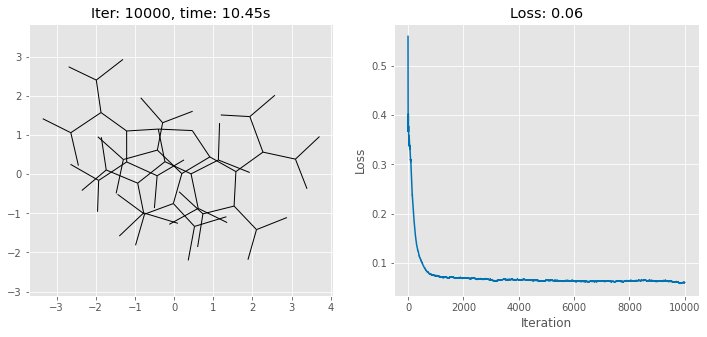

{'edge_uniformity', 'vertex_resolution'}



{'stress': 0.7278163098319639, 'edge_uniformity': 0.0018914343090727925, 'neighborhood_preservation': 0.9918699190020561, 'crossings': 337, 'crossing_angle_maximization': 0.9105086125923048, 'aspect_ratio': 0.3159794211387634, 'angular_resolution': 0.9019268825650215, 'vertex_resolution': 0.556364504963833, 'gabriel': 0.9783082734793425}


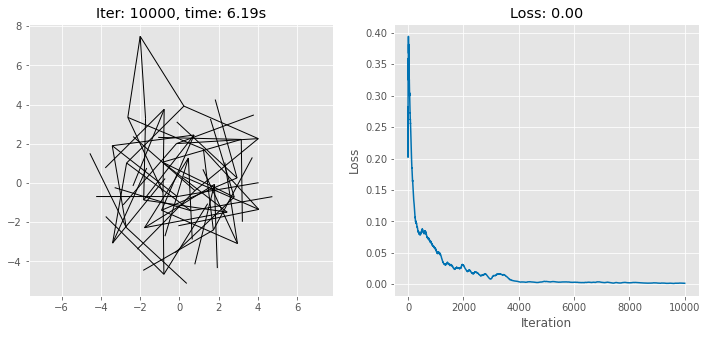

{'edge_uniformity', 'gabriel'}



{'stress': 265.21578215005434, 'edge_uniformity': 11.44263744354248, 'neighborhood_preservation': 0.5411764681339264, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.20931333303451538, 'angular_resolution': 0.7561886012554169, 'vertex_resolution': 0.6541389982637202, 'gabriel': 0.050553977489471436}


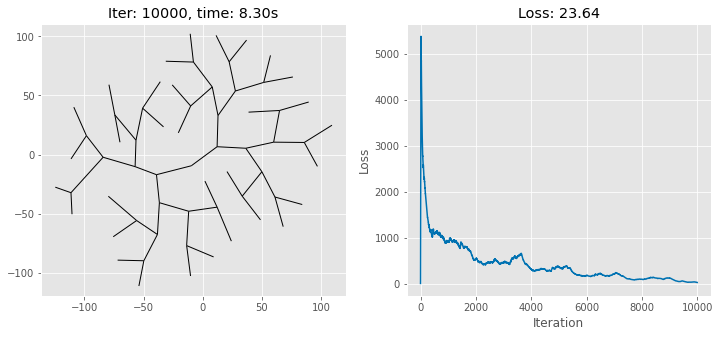

{'neighborhood_preservation'}



{'stress': 0.1523149088936147, 'edge_uniformity': 0.6186245679855347, 'neighborhood_preservation': 0.16296297311782837, 'crossings': 1, 'crossing_angle_maximization': 0.06109201990325283, 'aspect_ratio': 0.27150899171829224, 'angular_resolution': 0.7848340272903442, 'vertex_resolution': 0.8510629349956211, 'gabriel': 0.6965132653713226}


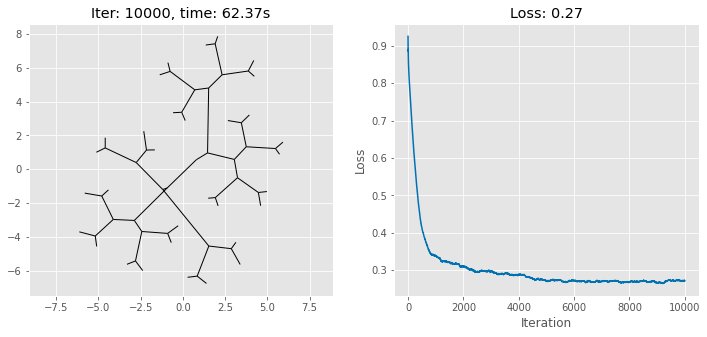

{'neighborhood_preservation', 'crossings'}



{'stress': 0.142636887857558, 'edge_uniformity': 0.5716787576675415, 'neighborhood_preservation': 0.10687023401260376, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.3363407850265503, 'angular_resolution': 0.32902973890304565, 'vertex_resolution': 0.8110735230890411, 'gabriel': 0.6381368041038513}


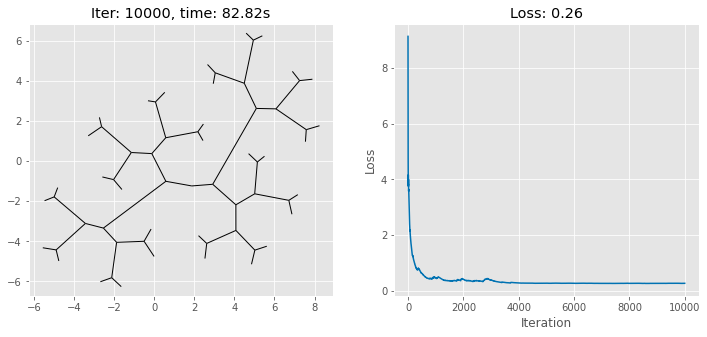

{'neighborhood_preservation', 'crossing_angle_maximization'}



{'stress': 0.25429897748557606, 'edge_uniformity': 1.1493072509765625, 'neighborhood_preservation': 0.31292515993118286, 'crossings': 8, 'crossing_angle_maximization': 0.19987106677217537, 'aspect_ratio': 0.06543087959289551, 'angular_resolution': 0.9424219056963921, 'vertex_resolution': 0.9668388879705037, 'gabriel': 0.7428529560565948}


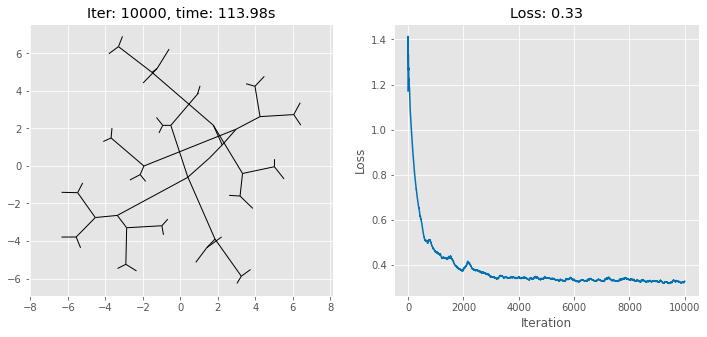

{'neighborhood_preservation', 'aspect_ratio'}



{'stress': 0.25799983387878284, 'edge_uniformity': 0.9320191740989685, 'neighborhood_preservation': 0.1764705777168274, 'crossings': 3, 'crossing_angle_maximization': 0.7178943182493048, 'aspect_ratio': 0.06902939081192017, 'angular_resolution': 0.541657030582428, 'vertex_resolution': 0.7641630384965055, 'gabriel': 0.9688963498920202}


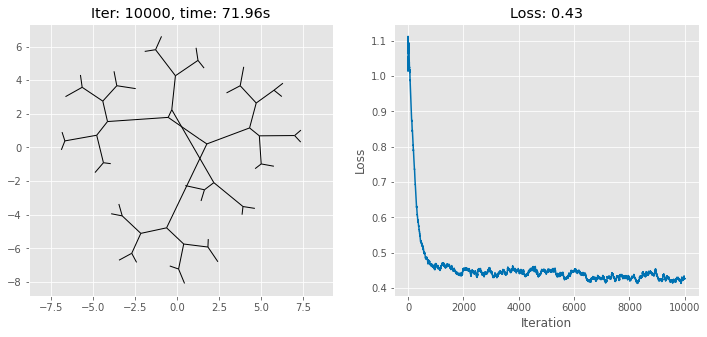

{'neighborhood_preservation', 'angular_resolution'}



{'stress': 0.23508071353285442, 'edge_uniformity': 0.9298814535140991, 'neighborhood_preservation': 0.13533836603164673, 'crossings': 4, 'crossing_angle_maximization': 0.7897854743582741, 'aspect_ratio': 0.2722528576850891, 'angular_resolution': 0.3996848464012146, 'vertex_resolution': 0.7713909520814083, 'gabriel': 0.8570553064346313}


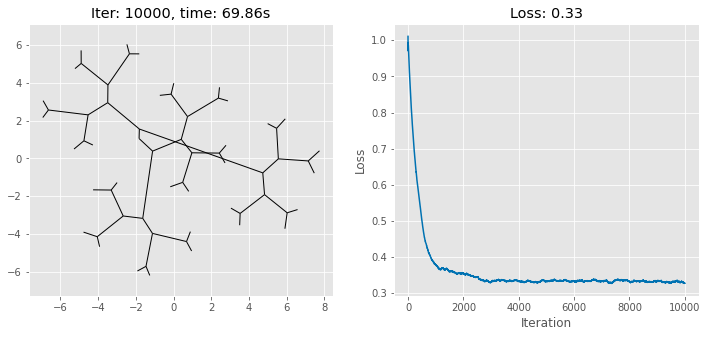

{'neighborhood_preservation', 'vertex_resolution'}



{'stress': 0.21704852998037327, 'edge_uniformity': 0.8292859196662903, 'neighborhood_preservation': 0.16296297311782837, 'crossings': 2, 'crossing_angle_maximization': 0.1497119030003896, 'aspect_ratio': 0.18499505519866943, 'angular_resolution': 0.9941482357680798, 'vertex_resolution': 0.7799228143251608, 'gabriel': 0.7407447695732117}


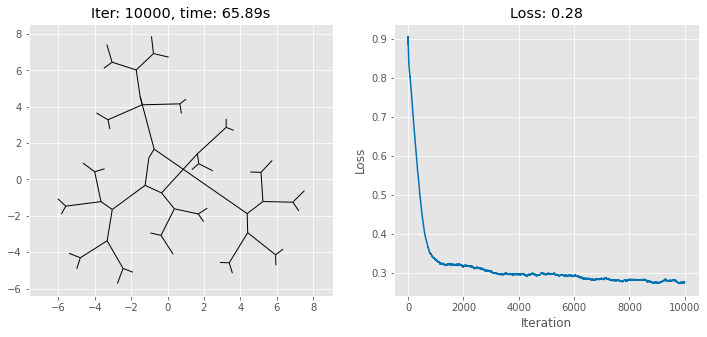

{'neighborhood_preservation', 'gabriel'}



{'stress': 298.28104813708387, 'edge_uniformity': 172.58331298828125, 'neighborhood_preservation': 0.6067415773868561, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.21051496267318726, 'angular_resolution': 0.9728688392788172, 'vertex_resolution': 0.8855493281479593, 'gabriel': 0.939326461404562}


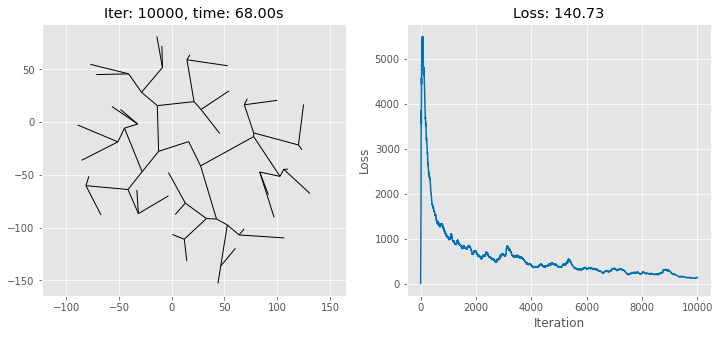

{'crossings'}



{'stress': 5.57426689482073, 'edge_uniformity': 32.131858825683594, 'neighborhood_preservation': 0.7843137234449387, 'crossings': 7, 'crossing_angle_maximization': 0.9119864378557232, 'aspect_ratio': 0.33040887117385864, 'angular_resolution': 0.9986829118570313, 'vertex_resolution': 0.9917056442824513, 'gabriel': 0.9297662153840065}


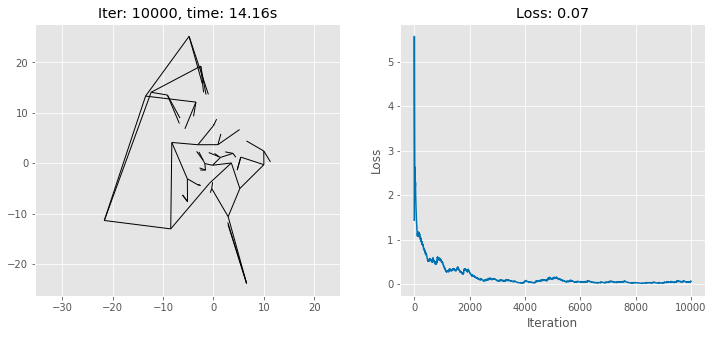

{'crossing_angle_maximization', 'crossings'}



{'stress': 11.671574648017737, 'edge_uniformity': 45.87287902832031, 'neighborhood_preservation': 0.7661691606044769, 'crossings': 7, 'crossing_angle_maximization': 0.046634558487086836, 'aspect_ratio': 0.20436054468154907, 'angular_resolution': 0.9990111594088376, 'vertex_resolution': 0.9762575191710193, 'gabriel': 0.9146512374281883}


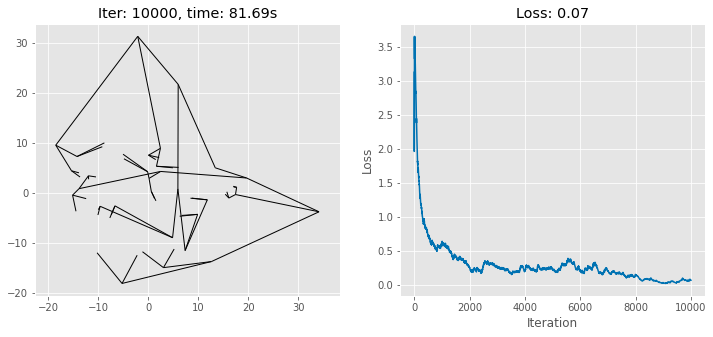

{'aspect_ratio', 'crossings'}



{'stress': 6.929017859413004, 'edge_uniformity': 13.516363143920898, 'neighborhood_preservation': 0.7783251255750656, 'crossings': 16, 'crossing_angle_maximization': 0.9806490394350181, 'aspect_ratio': 0.15981149673461914, 'angular_resolution': 0.9904918074607849, 'vertex_resolution': 0.9592407161959738, 'gabriel': 0.8912560269236565}


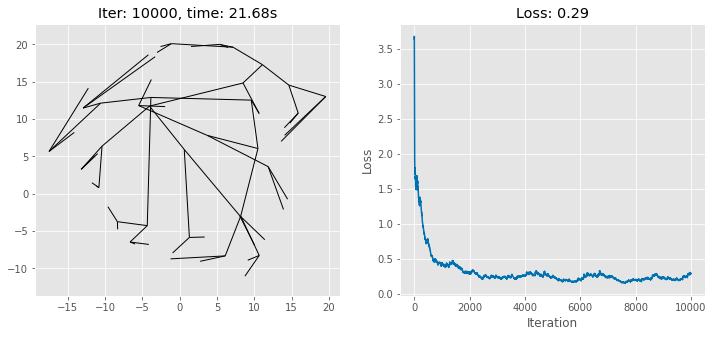

{'angular_resolution', 'crossings'}



{'stress': 4.910877616327287, 'edge_uniformity': 23.113725662231445, 'neighborhood_preservation': 0.6594594717025757, 'crossings': 1, 'crossing_angle_maximization': 0.025413084844866443, 'aspect_ratio': 0.2132592797279358, 'angular_resolution': 0.9824557490646839, 'vertex_resolution': 0.9175725805951447, 'gabriel': 0.9503066278994083}


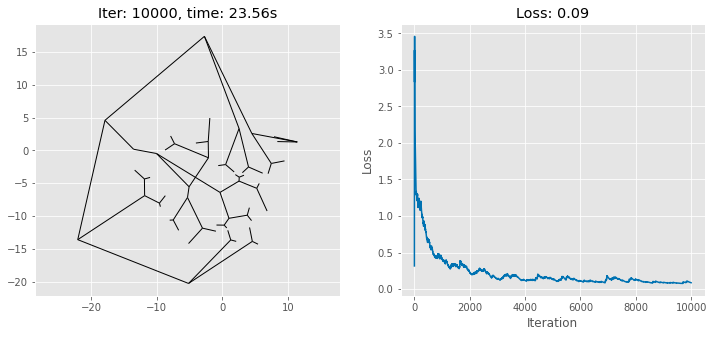

{'vertex_resolution', 'crossings'}



{'stress': 4.883929598899373, 'edge_uniformity': 11.889591217041016, 'neighborhood_preservation': 0.7783251255750656, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.31012922525405884, 'angular_resolution': 0.9988447873620316, 'vertex_resolution': 0.755188977885954, 'gabriel': 0.8916560485959053}


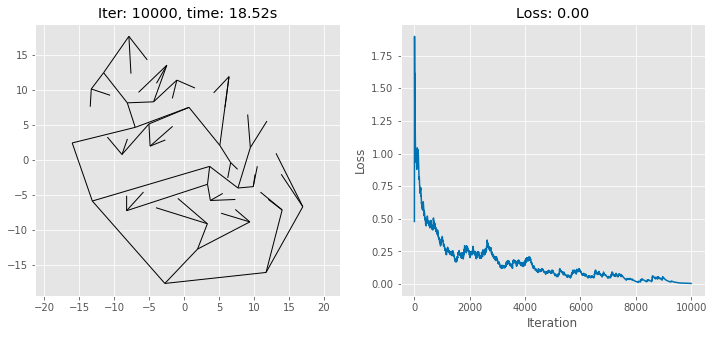

{'gabriel', 'crossings'}



{'stress': 307.5409298769507, 'edge_uniformity': 99.7283935546875, 'neighborhood_preservation': 0.6373626291751862, 'crossings': 4, 'crossing_angle_maximization': 0.7200226051946809, 'aspect_ratio': 0.30380845069885254, 'angular_resolution': 0.9850881034508348, 'vertex_resolution': 0.8583958352333654, 'gabriel': 0.5863276422023773}


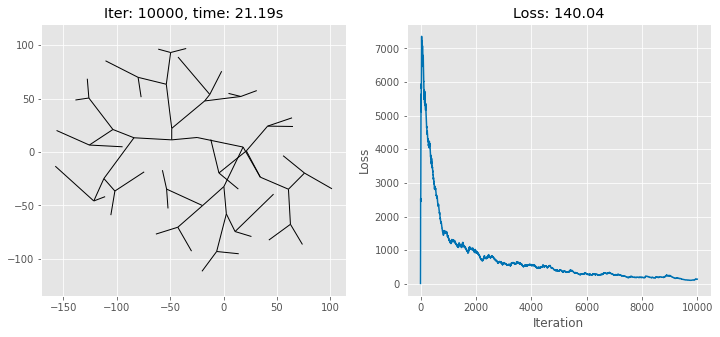

{'crossing_angle_maximization'}



{'stress': 0.7493685970760037, 'edge_uniformity': 2.0927958488464355, 'neighborhood_preservation': 1.0, 'crossings': 360, 'crossing_angle_maximization': 1.0000000278275352, 'aspect_ratio': 0.045901596546173096, 'angular_resolution': 1.0, 'vertex_resolution': 0.9887458401270203, 'gabriel': 0.9783031940460205}


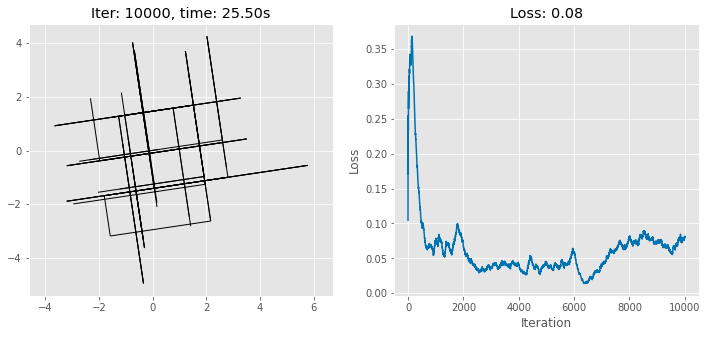

{'aspect_ratio', 'crossing_angle_maximization'}



{'stress': 11.966270984281818, 'edge_uniformity': 49.48773193359375, 'neighborhood_preservation': 0.9709543567150831, 'crossings': 377, 'crossing_angle_maximization': 0.9981610373390046, 'aspect_ratio': 0.0746193528175354, 'angular_resolution': 0.9993580760783516, 'vertex_resolution': 0.9707748004901148, 'gabriel': 0.9364524632692337}


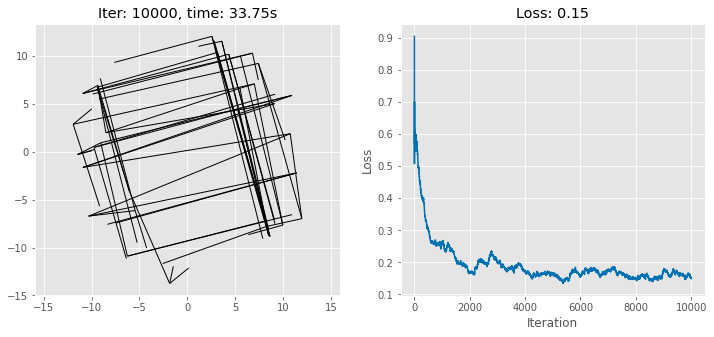

{'angular_resolution', 'crossing_angle_maximization'}



{'stress': 1.0403253252118438, 'edge_uniformity': 4.294218063354492, 'neighborhood_preservation': 1.0, 'crossings': 356, 'crossing_angle_maximization': 0.992766402150547, 'aspect_ratio': 0.2599436640739441, 'angular_resolution': 0.9997171732538845, 'vertex_resolution': 0.9833797299232675, 'gabriel': 0.987088461406529}


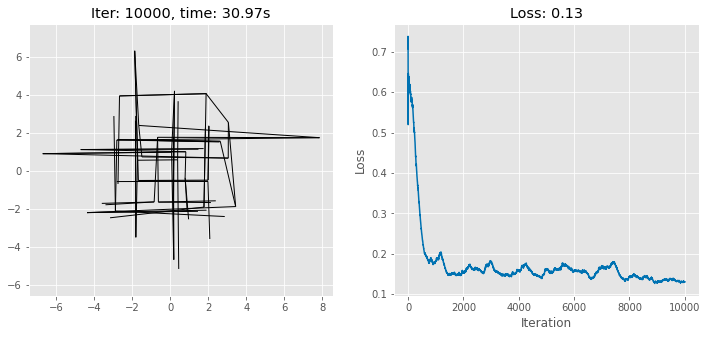

{'vertex_resolution', 'crossing_angle_maximization'}



{'stress': 1.590386204415371, 'edge_uniformity': 6.8270063400268555, 'neighborhood_preservation': 0.9918699190020561, 'crossings': 509, 'crossing_angle_maximization': 0.9986098566584652, 'aspect_ratio': 0.11231458187103271, 'angular_resolution': 0.9999503672916035, 'vertex_resolution': 0.5037338804859091, 'gabriel': 0.9937490811571479}


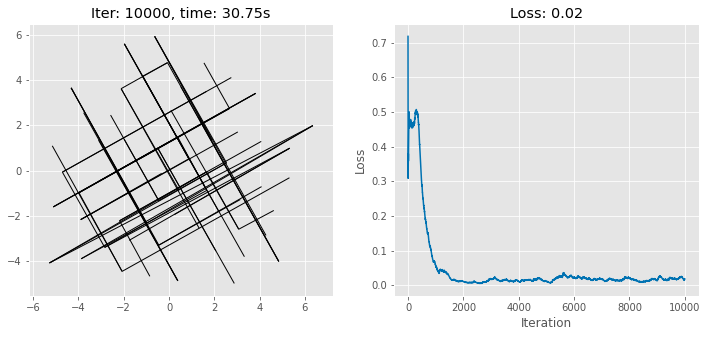

{'gabriel', 'crossing_angle_maximization'}



{'stress': 322.8267469382299, 'edge_uniformity': 151.80953979492188, 'neighborhood_preservation': 0.6298342645168304, 'crossings': 1, 'crossing_angle_maximization': 0.23453609819376872, 'aspect_ratio': 0.17835891246795654, 'angular_resolution': 0.917098805308342, 'vertex_resolution': 0.7536541155035474, 'gabriel': 0.7861490845680237}


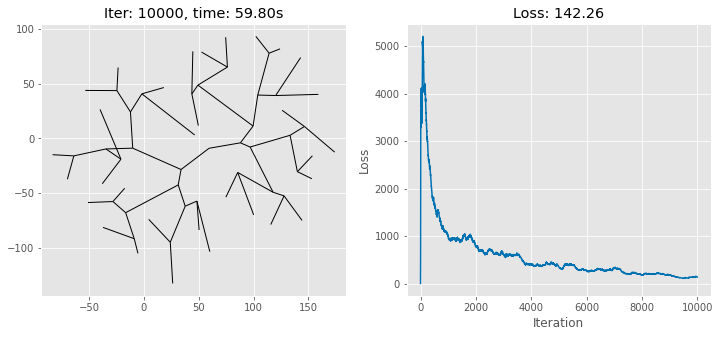

{'aspect_ratio'}



{'stress': 11.909146754227079, 'edge_uniformity': 40.97516632080078, 'neighborhood_preservation': 0.9752066116780043, 'crossings': 432, 'crossing_angle_maximization': 0.979470148784274, 'aspect_ratio': 0.027907729148864746, 'angular_resolution': 0.9942326880991459, 'vertex_resolution': 0.8809646427154905, 'gabriel': 0.9247318059206009}


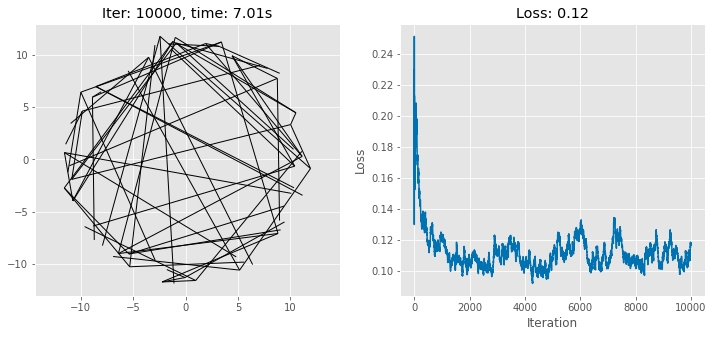

{'angular_resolution', 'aspect_ratio'}



{'stress': 11.694585401525147, 'edge_uniformity': 57.250946044921875, 'neighborhood_preservation': 0.8977777808904648, 'crossings': 327, 'crossing_angle_maximization': 0.9555841424558408, 'aspect_ratio': 0.02216339111328125, 'angular_resolution': 0.8917160332202911, 'vertex_resolution': 0.9101444988739652, 'gabriel': 0.952533446252346}


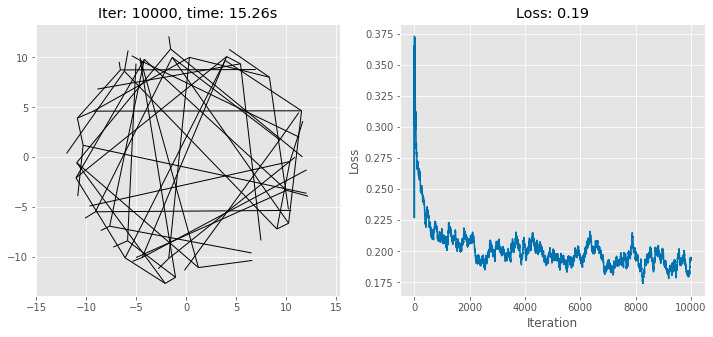

{'vertex_resolution', 'aspect_ratio'}



{'stress': 12.624177492914002, 'edge_uniformity': 46.03959274291992, 'neighborhood_preservation': 0.9709543567150831, 'crossings': 537, 'crossing_angle_maximization': 0.9357200550746743, 'aspect_ratio': 0.06804162263870239, 'angular_resolution': 0.9711786508560181, 'vertex_resolution': 0.8086361480603146, 'gabriel': 0.9452988915145397}


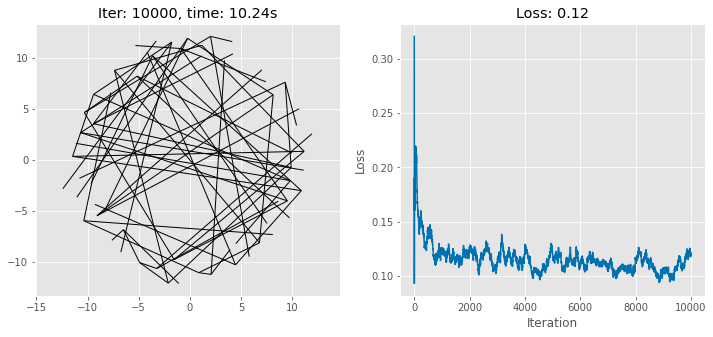

{'gabriel', 'aspect_ratio'}



{'stress': 368.53142329418154, 'edge_uniformity': 177.5506591796875, 'neighborhood_preservation': 0.6878306865692139, 'crossings': 6, 'crossing_angle_maximization': 0.3657844820477983, 'aspect_ratio': 0.0797872543334961, 'angular_resolution': 0.9881845125928521, 'vertex_resolution': 0.8793795640053474, 'gabriel': 0.7859163582324982}


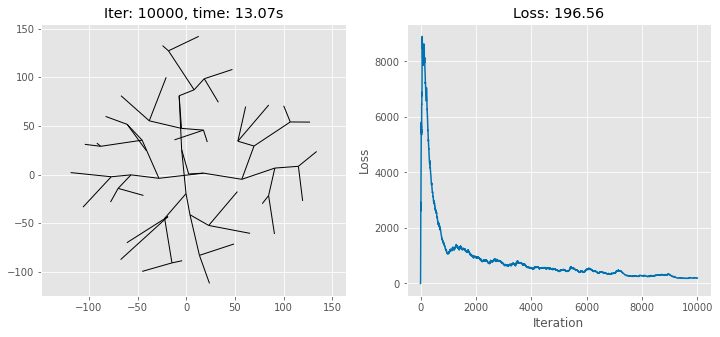

{'angular_resolution'}



{'stress': 0.364834942026656, 'edge_uniformity': 0.7202925086021423, 'neighborhood_preservation': 0.9446808509528637, 'crossings': 86, 'crossing_angle_maximization': 0.9076504060976268, 'aspect_ratio': 0.122261643409729, 'angular_resolution': 0.4646821618080139, 'vertex_resolution': 0.9878187426037423, 'gabriel': 0.9332085847854614}


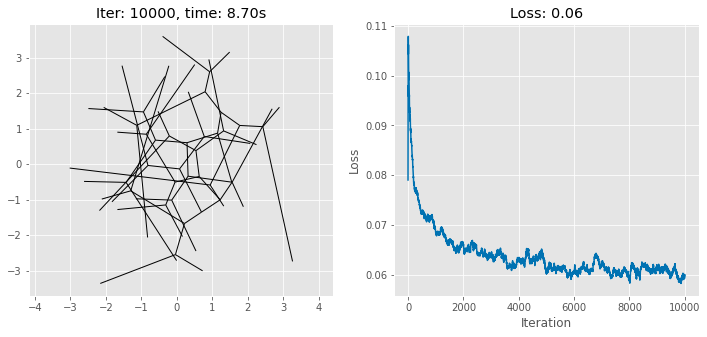

{'vertex_resolution', 'angular_resolution'}



{'stress': 0.5838022325571772, 'edge_uniformity': 3.8493664264678955, 'neighborhood_preservation': 0.83568075299263, 'crossings': 129, 'crossing_angle_maximization': 0.9256478786696196, 'aspect_ratio': 0.0693349838256836, 'angular_resolution': 0.7642312049865723, 'vertex_resolution': 0.5329133192767942, 'gabriel': 0.9677074290812016}


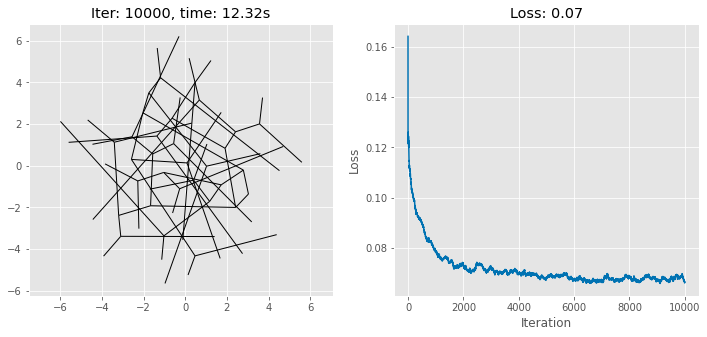

{'gabriel', 'angular_resolution'}



{'stress': 354.5640136554259, 'edge_uniformity': 225.37277221679688, 'neighborhood_preservation': 0.7015706896781921, 'crossings': 5, 'crossing_angle_maximization': 0.6564295976903417, 'aspect_ratio': 0.09983682632446289, 'angular_resolution': 0.9865186866372824, 'vertex_resolution': 0.8746304894660624, 'gabriel': 0.7532661706209183}


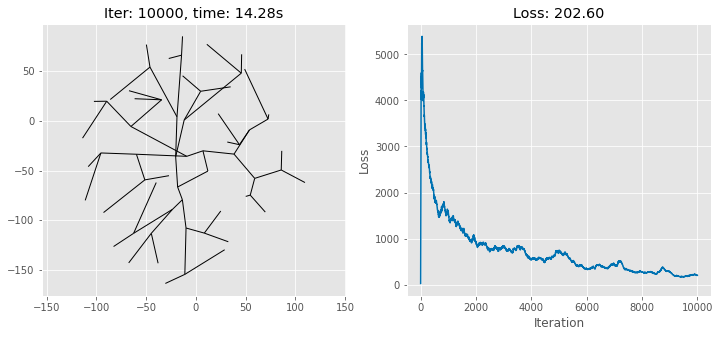

{'vertex_resolution'}



{'stress': 0.6409452664878107, 'edge_uniformity': 2.5312306880950928, 'neighborhood_preservation': 0.9877551021054387, 'crossings': 428, 'crossing_angle_maximization': 0.9494806854135175, 'aspect_ratio': 0.0662195086479187, 'angular_resolution': 0.9845712576061487, 'vertex_resolution': 0.18065011598324276, 'gabriel': 0.9664761684834957}


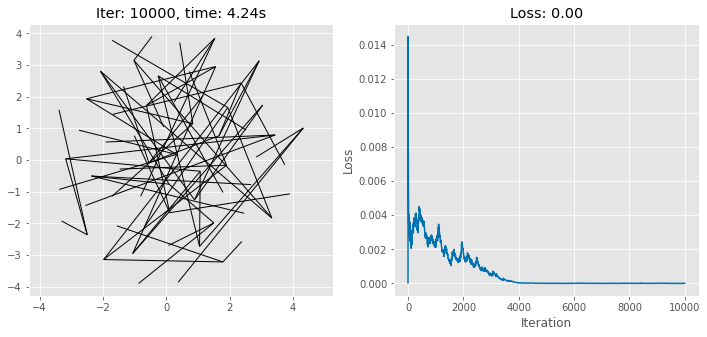

{'gabriel', 'vertex_resolution'}



{'stress': 307.98595477051697, 'edge_uniformity': 147.29238891601562, 'neighborhood_preservation': 0.5664739906787872, 'crossings': 1, 'crossing_angle_maximization': 0.07099260677815865, 'aspect_ratio': 0.23363065719604492, 'angular_resolution': 0.9215305745601654, 'vertex_resolution': 0.8614610276928091, 'gabriel': 0.6749820411205292}


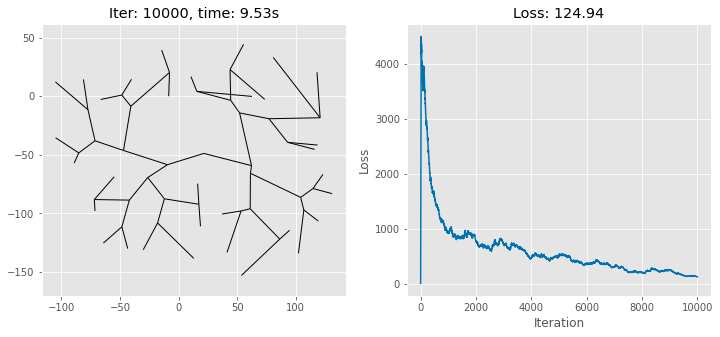

{'gabriel'}



{'stress': 314.4530815644259, 'edge_uniformity': 121.42571258544922, 'neighborhood_preservation': 0.6067415773868561, 'crossings': 0, 'crossing_angle_maximization': 0, 'aspect_ratio': 0.17281073331832886, 'angular_resolution': 0.8861445039510727, 'vertex_resolution': 0.986476164610458, 'gabriel': 0.6178299188613892}


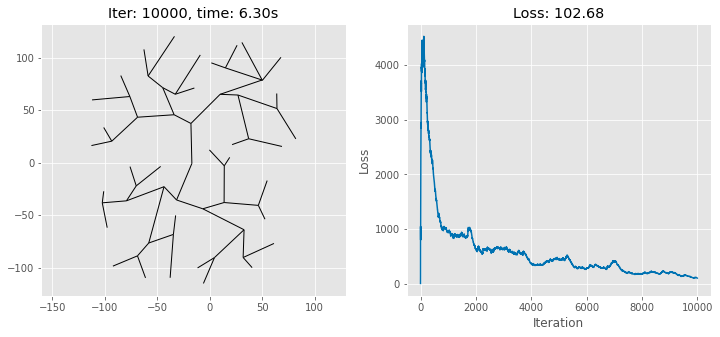

CPU times: user 1h 9min 49s, sys: 9.85 s, total: 1h 9min 59s
Wall time: 25min 39s


In [41]:
%%time


import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2
importlib.reload(gd2)
from gd2 import GD2









criteria_weights = dict(
    stress=1,
    edge_uniformity=0.5,
    neighborhood_preservation=0.5,
    crossings=1,
    crossing_angle_maximization=0.1,
    aspect_ratio=10,
    angular_resolution=0.01,
    vertex_resolution=0.05,
    gabriel=0.01,
)

sample_sizes = dict(
    stress=64,
    edge_uniformity=int(len(G)**0.5),
    neighborhood_preservation=16,
    crossings=16,
    crossing_angle_maximization=10,
    aspect_ratio=int(len(G)**0.5),
    angular_resolution=32,
    vertex_resolution=int(len(G)**0.5),
#     vertex_resolution=len(G),
    gabriel=10,
)




## choose criteria
criteria_all = [
    'stress',
    'edge_uniformity',
    'neighborhood_preservation',
    'crossings',
    'crossing_angle_maximization',
    'aspect_ratio',
    'angular_resolution',
    'vertex_resolution',
    'gabriel',
]
for i,c1 in enumerate(criteria_all):
    for c2 in criteria_all[i:]: ##all pairs and singletons
#     for c2 in criteria_all[i+1:]:##all pairs, without singletons
    
        criteria_pair = {c1,c2}
        print(criteria_pair)
        
        gd = GD2(G)

        result = gd.optimize(
            criteria_weights={c:criteria_weights[c] for c in criteria_pair}, 
            sample_sizes=sample_sizes,
            evaluate=criteria_all,

            max_iter=10000, 
            evaluate_interval=10000//40,
            vis_interval=-10000//10,
#             clear_output=True,
            
            optimizer_kwargs = dict(lr=2),
            scheduler_kwargs = dict(verbose=False),
        )
        print(result['qualities'])
        
        pos = gd.pos.detach().numpy()
        pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
        vis.plot(
            gd.G, pos_G,
            gd.loss_curve, 
            result['iter'], result['runtime'],
            edge=True, show=True, save=False
        )
        
        
        
        ## store data
        if c1 == c2:
            fn = c1
        else:
            fn = f'{c1}-vs-{c2}'
        dump(gd, f'{dir_out}/{fn}.pkl')




## plot examples in a matrix

In [43]:
import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)
import gd2
importlib.reload(gd2)
from gd2 import GD2

In [44]:
from matplotlib.gridspec import GridSpec

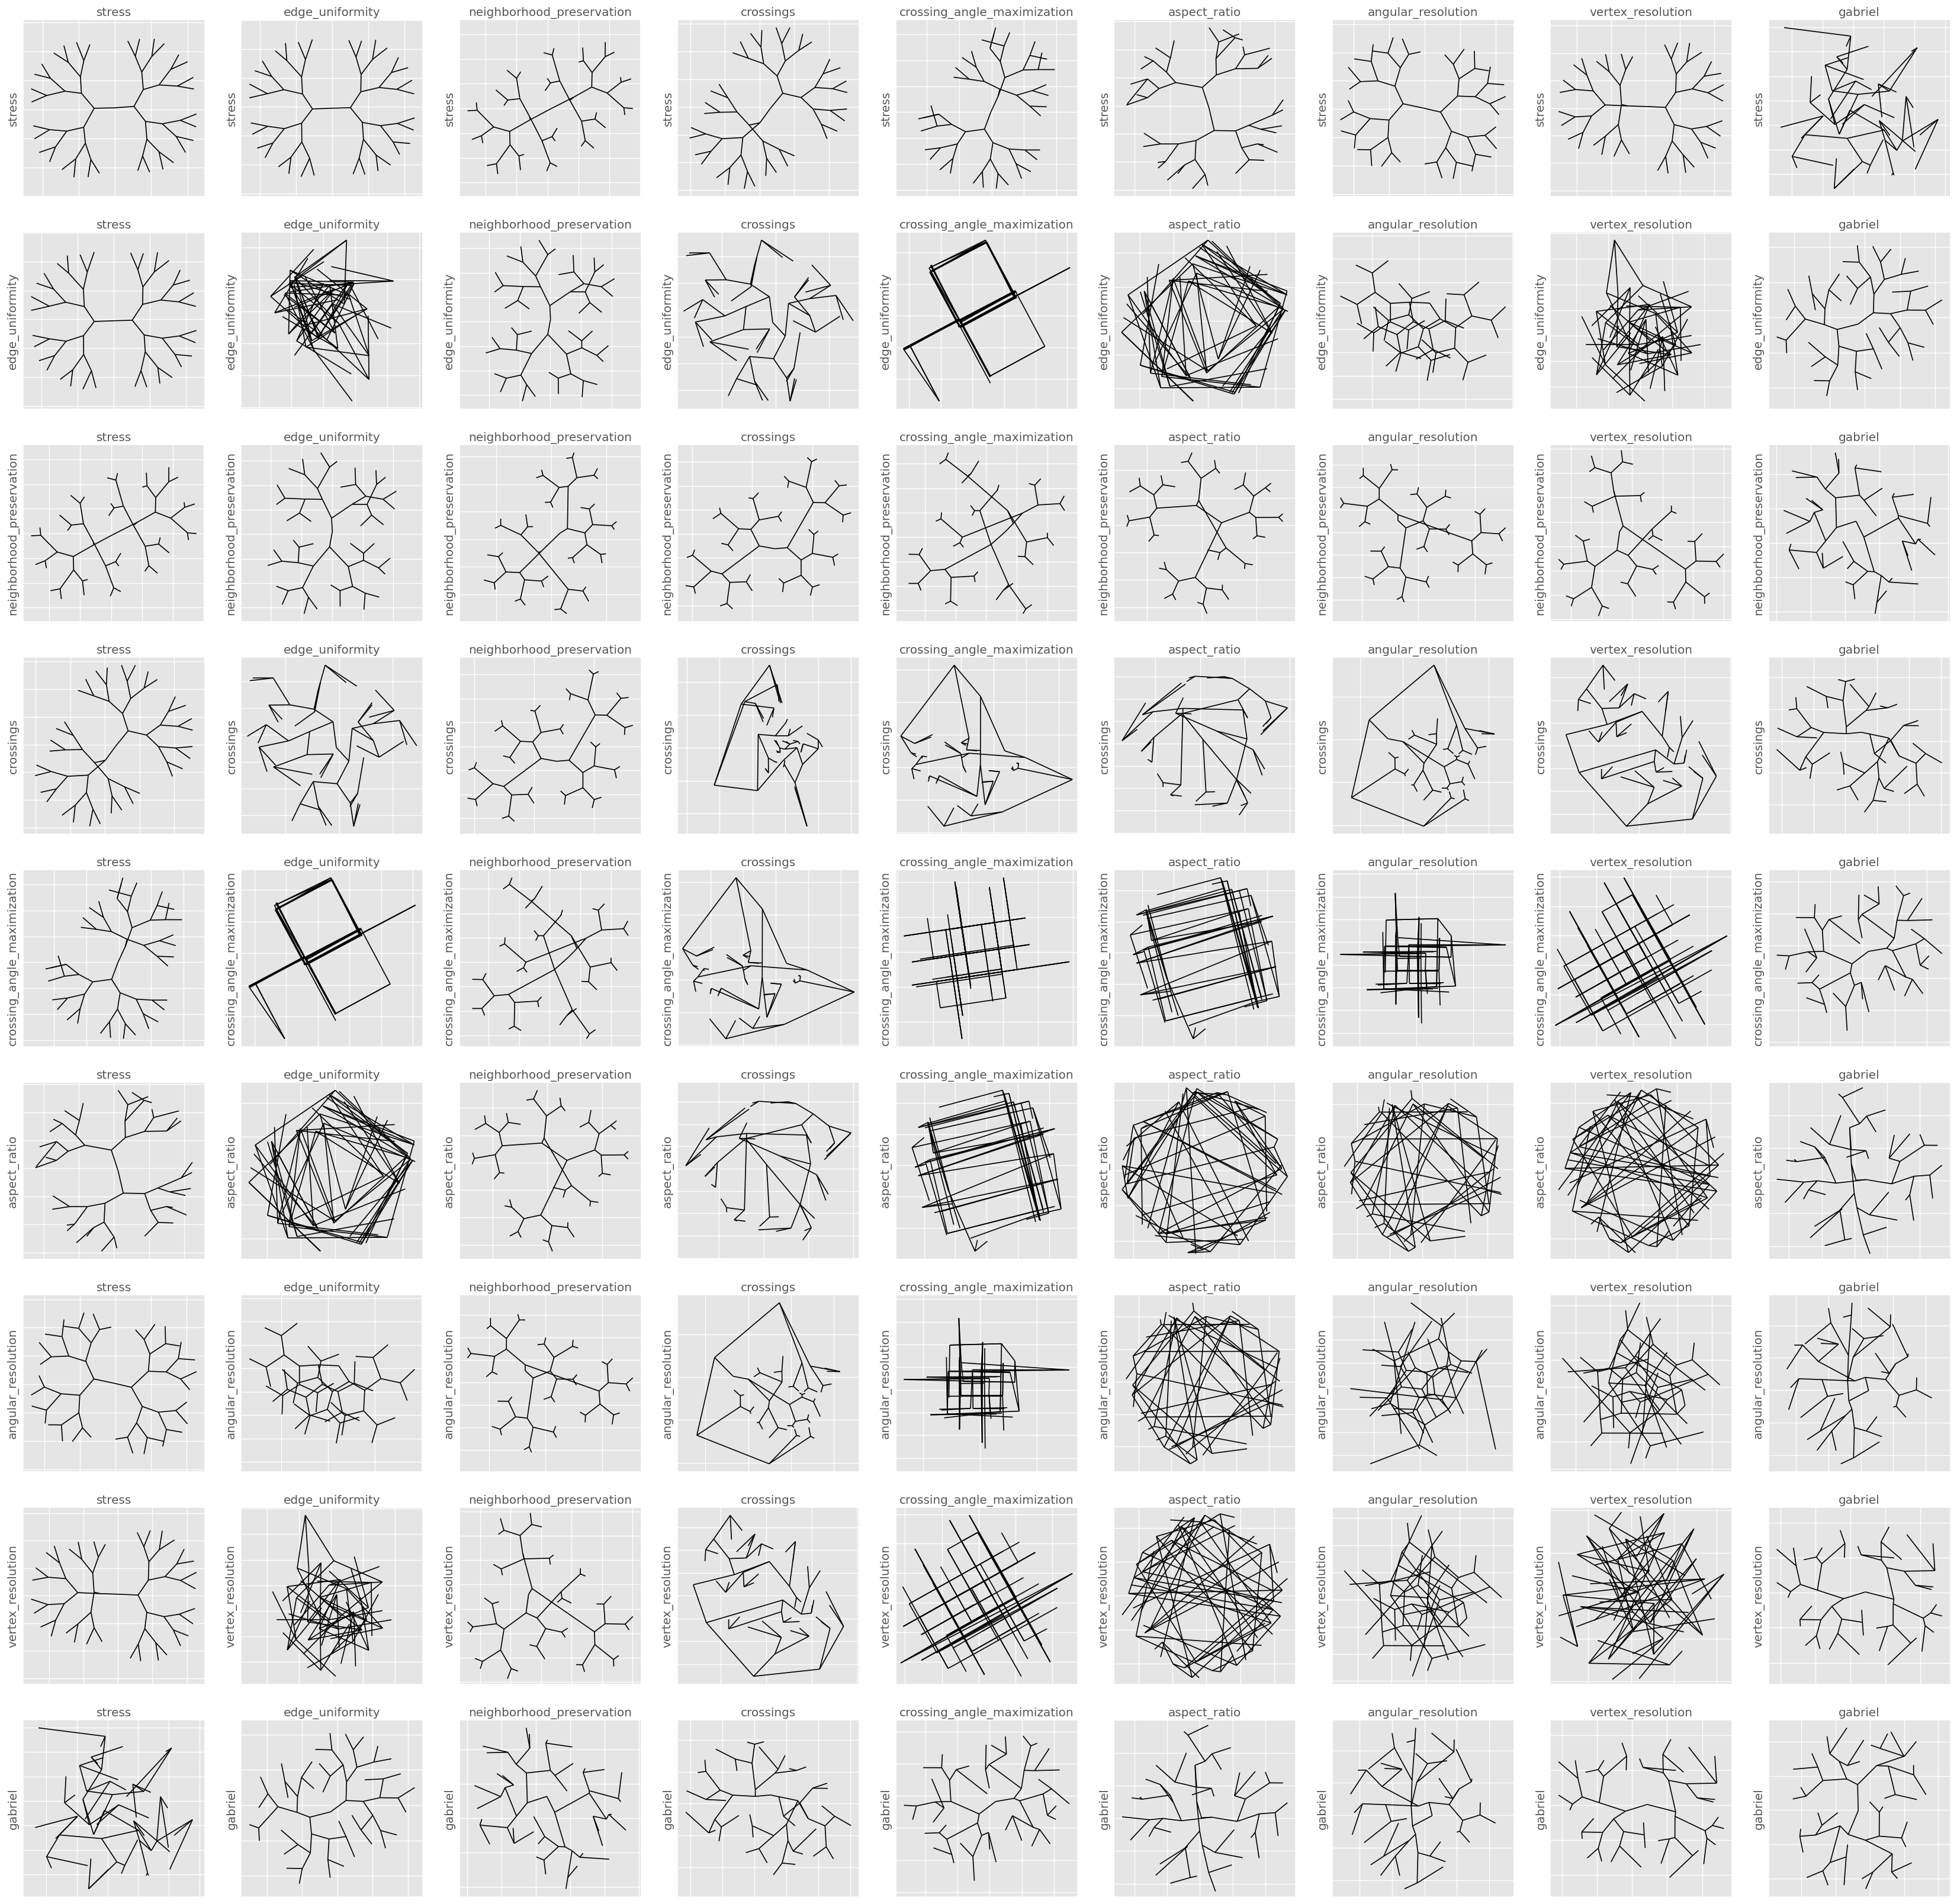

In [68]:
# dir_in = './analysis/criteria_pairs/tree_2_6-0'
# dir_in = './analysis/criteria_pairs/tree_2_5-t1633627830'
dir_in = './analysis/criteria_pairs/tree_2_5-t1633984153'


criteria_all = [
    'stress',
    'edge_uniformity',
    'neighborhood_preservation',
    'crossings',
    'crossing_angle_maximization',
    'aspect_ratio',
    'angular_resolution',
    'vertex_resolution',
    'gabriel',
]
n = len(criteria_all)


# mode = 'criteria_pairs'
mode = 'drawings'
# mode = 'learning_curves'


dpi = 120
if mode == 'drawings':
    space = 0.2
    figsize = [35,35]
else:
    space = 0.3
    figsize = [40,40]
    
fig = plt.figure(figsize=figsize, dpi=dpi)
gs = GridSpec(n,n, wspace=space, hspace=space)


for i,c1 in enumerate(criteria_all):
#     for j,c2 in enumerate(criteria_all[i:],i): ##all pairs and singletons
    for j,c2 in enumerate(criteria_all): ##all pairs and singletons
        
        if c1 == c2:
            fn = c1
        elif i<j:
            fn = f'{c1}-vs-{c2}'
        elif i>j:
            fn = f'{c2}-vs-{c1}'
            
        with open(f'{dir_in}/{fn}.pkl', 'rb') as f:
            data = pkl.load(f)
#             ax = plt.subplot(gs[(n-1)-i,j])
            ax = plt.subplot(gs[i,j])
            
            if mode == 'drawings':
                ## draw graphs
                pos = data['pos'].detach().numpy()
                pos_G = {k:pos[data['k2i'][k]] for k in data['G'].nodes}
                vis.draw_graph(
                    data['G'], pos_G, ax=ax,
                    ylabel=c1,# if j==0 else '',
                    xlabel=c2,# if i==0 else '',
                )
                ax.xaxis.set_label_position('top')
                plt.axis('equal')
                ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            
            
            elif mode == 'criteria_pairs':
                ## plot learn curves
                t = [r['time'] for r in data['qualities_by_time']]
                quality_curve_x = [r['qualities'][c2] for r in data['qualities_by_time']]
                quality_curve_y = [r['qualities'][c1] for r in data['qualities_by_time']]
                plt.scatter(quality_curve_x, quality_curve_y, s=50, c=t)
                plt.xlabel(c2)
                plt.ylabel(c1)
                
                
            elif mode == 'learning_curves':
                ## plot quality curves       
                t = [r['time'] for r in data['qualities_by_time']]
                for c in criteria_all:
                    quality_curve = np.array([r['qualities'][c] for r in data['qualities_by_time']])
                    if c in {'stress', 'crossings', 'edge_uniformity'}:
                        quality_curve = quality_curve/quality_curve.max()
                        
                    if c == c1:
                        color, alpha, style = 'C0', 1.0, '-'
                    elif c == c2:
                        color, alpha, style = 'C1', 1.0, '-'
                    else:
                        color, alpha, style = '#aaa', 1.0, '-'
                    plt.plot(
                        t, quality_curve, 
                        style, 
                        label=c if c==c1 or c==c2 else None,
                        lw=2 if c==c1 or c==c2 else 0.5,
                        color=color,
                        alpha=alpha
                    )
                plt.xlabel('Time')
                plt.ylabel('Quality')
#                 plt.title(f'{c1} vs. {c2}')
                plt.legend()
                plt.ylim([-0.1, 1.5])
    
plt.savefig(f'{mode}-matrix.png', bbox_inches='tight', dpi=dpi)
plt.show()
            


## testing reyans hyper cubes

In [ ]:
import json
log_dir = 'reyan/log_folder/'
problematic_files = ['input_11.txt', 'input_18.txt', 'input_26.txt', 'input_27.txt', 'input_28.txt', 'input_48.txt', 'input_56.txt', 'input_63.txt', 'input_70.txt', 'input_71.txt', 'input_73.txt', 'input_74.txt', 'input_75.txt', 'input_76.txt', 'input_93.txt', 'input_94.txt', 'input_95.txt', 'input_101.txt', 'input_102.txt', 'input_103.txt', 'input_108.txt', 'input_109.txt', 'input_110.txt', 'input_115.txt', 'input_116.txt', 'input_117.txt', 'input_118.txt', 'input_120.txt', 'input_121.txt', 'input_122.txt', 'input_123.txt', 'input_124.txt', 'input_125.txt', 'input_126.txt', 'input_127.txt', 'input_128.txt', 'input_129.txt', 'input_134.txt', 'input_137.txt', 'input_138.txt', 'input_139.txt', 'input_140.txt', 'input_146.txt', 'input_147.txt', 'input_148.txt', 'input_153.txt', 'input_154.txt', 'input_155.txt', 'input_157.txt', 'input_160.txt', 'input_161.txt', 'input_162.txt', 'input_163.txt', 'input_164.txt', 'input_166.txt', 'input_167.txt', 'input_168.txt', 'input_169.txt', 'input_170.txt', 'input_171.txt', 'input_172.txt', 'input_173.txt', 'input_174.txt', 'input_179.txt', 'input_183.txt', 'input_184.txt', 'input_185.txt', 'input_191.txt', 'input_192.txt', 'input_193.txt', 'input_198.txt', 'input_199.txt', 'input_200.txt', 'input_202.txt', 'input_205.txt', 'input_206.txt', 'input_208.txt', 'input_209.txt', 'input_211.txt', 'input_212.txt', 'input_213.txt', 'input_214.txt', 'input_215.txt', 'input_216.txt', 'input_217.txt', 'input_218.txt', 'input_219.txt', 'input_224.txt']
pairs = []
for fn in problematic_files:
    with open(log_dir+fn) as f:
        params = json.load(f)
        graph_str = f'{params["graph"]} {params["graph_param_1"]}'
        pairs.append(
            (tuple(sorted(params['metrics'])),)
            +(graph_str,fn.split('/')[-1].split('.')[0])
        )
        
# for criteria, graph, fn in natsorted(pairs, key=lambda x:x[-1]):
for criteria, graph, fn in natsorted(pairs, key=lambda x:x):
    print(f'{graph}\t{fn:<12} {criteria} ')

In [ ]:
from pathlib import Path

In [ ]:
log_dir = 'log_folder/'
problematic_files = ['input_11.txt', 'input_18.txt', 'input_26.txt', 'input_27.txt', 'input_28.txt', 'input_48.txt', 'input_56.txt', 'input_63.txt', 'input_70.txt', 'input_71.txt', 'input_73.txt', 'input_74.txt', 'input_75.txt', 'input_76.txt', 'input_93.txt', 'input_94.txt', 'input_95.txt', 'input_101.txt', 'input_102.txt', 'input_103.txt', 'input_108.txt', 'input_109.txt', 'input_110.txt', 'input_115.txt', 'input_116.txt', 'input_117.txt', 'input_118.txt', 'input_120.txt', 'input_121.txt', 'input_122.txt', 'input_123.txt', 'input_124.txt', 'input_125.txt', 'input_126.txt', 'input_127.txt', 'input_128.txt', 'input_129.txt', 'input_134.txt', 'input_137.txt', 'input_138.txt', 'input_139.txt', 'input_140.txt', 'input_146.txt', 'input_147.txt', 'input_148.txt', 'input_153.txt', 'input_154.txt', 'input_155.txt', 'input_157.txt', 'input_160.txt', 'input_161.txt', 'input_162.txt', 'input_163.txt', 'input_164.txt', 'input_166.txt', 'input_167.txt', 'input_168.txt', 'input_169.txt', 'input_170.txt', 'input_171.txt', 'input_172.txt', 'input_173.txt', 'input_174.txt', 'input_179.txt', 'input_183.txt', 'input_184.txt', 'input_185.txt', 'input_191.txt', 'input_192.txt', 'input_193.txt', 'input_198.txt', 'input_199.txt', 'input_200.txt', 'input_202.txt', 'input_205.txt', 'input_206.txt', 'input_208.txt', 'input_209.txt', 'input_211.txt', 'input_212.txt', 'input_213.txt', 'input_214.txt', 'input_215.txt', 'input_216.txt', 'input_217.txt', 'input_218.txt', 'input_219.txt', 'input_224.txt']

for fn in problematic_files:
        
    with open(log_dir+fn) as json_file:
        input_param = json.load(json_file)
    
    graph_str = (
        input_param['graph']
        + ' ' 
        + ' '.join(input_param[k] for k in natsorted(input_param) if k.startswith('graph_param_'))
    )
    metrics = input_param['metrics']
    print(f'='*40)
    print(f'fn: {fn}')
    print(f'metrics: {metrics}')
    print(f'graph: {graph_str}')
    
    if Path(input_param["output_file"]).exists():
        continue
          
    print('generating graph', end=' ')
    if input_param["graph"]=="tree":
        G = nx.balanced_tree(int(input_param["graph_param_1"]), int(input_param["graph_param_2"]))
    elif input_param["graph"]=="hypercube":
        G = nx.hypercube_graph(int(input_param["graph_param_1"]))
    elif input_param["graph"]=="grid":
        dim = int(input_param["graph_param_1"])
        G = nx.grid_graph(dim = [dim, dim])
    print(f'of {len(G)} nodes')
    
    max_iter = 10000
    criteria_weights_default = {
        'stress': 4,
        'edge_uniformity':1,
        'neighborhood_preservation':0.5,
        'crossings':1,
        'crossing_angle_maximization':0.1,
        'aspect_ratio':10,
        'angular_resolution':0.1,
        'vertex_resolution':1,
        'gabriel':0.01,
    }

    sample_sizes_default = {
        'stress': 64,
        'edge_uniformity': 10,
        'neighborhood_preservation': 16,
        'crossings': 10,
        'crossing_angle_maximization':10,
        'aspect_ratio': 'full',
        'angular_resolution': 10,
        'vertex_resolution': int(len(G)**0.5),
        'gabriel': 10,
    }


    criteria_weights = {}
    for m in input_param['metrics']:
        criteria_weights[m] = criteria_weights_default[m]


    gd = GD2(G)
    result = gd.optimize(
        criteria_weights=criteria_weights,
        sample_sizes=sample_sizes_default,

        evaluate='all',
    #     evaluate={'neighborhood_preservation'},
#         evaluate=set(input_param['metrics']),

        max_iter=max_iter, 
        evaluate_interval=-1,
        vis_interval=-1,

        optimizer_kwargs = dict(lr=1),
        scheduler_kwargs = dict(verbose=False),
    )


    for q,v in result['qualities'].items():
        print(q,v)

    return_dict = dict(
        metric_value=result['qualities'],
        pos=result['pos'].detach().cpu().tolist(),
        time=result['runtime']
    )
    
    with open(input_param["output_file"], 'w') as fp:
        json.dump(return_dict, fp)
          
          
    ## vis for debugging
    pos = gd.pos.detach().numpy()
    pos_G = {k:pos[gd.k2i[k]] for k in gd.G.nodes}
    vis.plot(
        gd.G, pos_G,
        gd.loss_curve, 
        result['iter'], result['runtime'],
        edge=True, show=True, save=False
    )

    

In [ ]:

# from utils import lovasz_losses as L
# a = torch.eye(5)
# pred = torch.randn(5,5)
# L.lovasz_softmax(pred, a)

## Analysis of sample size

In [ ]:
# import importlib
# importlib.reload(C)
# importlib.reload(Q)
# importlib.reload(utils)
# importlib.reload(vis)
# importlib.reload(gd2)

In [ ]:
import pandas as pd
import itertools

In [ ]:
df

In [ ]:
# cm = plt.cm.viridis()

# for result in results:
    
#     sample_size = result['sample_sizes']['stress']
    
#     t = [x['time'] for x in result['qualities_by_time']]
#     stress = [x['qualities']['stress'] for x in result['qualities_by_time']]
    
#     plt.plot(t, stress, '.-', label=f'sample_size = {sample_size}', color=cm(np.log2(sample_size)/np.log2(512)))
    
# plt.xlabel('Total Time (sec)')
# plt.ylabel('Stress')
# plt.yscale('log')

# plt.xlim([-10,100])
# plt.legend()
# plt.savefig('time-vs-stress-curve-by-sample-size-100sec.png')
# plt.show()

In [ ]:
# df.to_csv('./analysis/balanced-tree-2-8.csv')

In [ ]:
df.plot('sample_size', 'runtime', style='o')
df.plot('sample_size', 'stress', style='o');

In [ ]:
plt.scatter(
    df['runtime'], 
    df['stress'], 
    s=df['sample_size']+10, 
    linewidth=1,
    edgecolor='#eee',
    alpha=0.8,
#     c=df['sample_size']+10,
    label='Sample Size',
)

# plt.xscale('symlog')
plt.xlabel('Runtime')
plt.xlim([0, plt.xlim()[1]*1.1])

# plt.yscale('log')
plt.ylabel('Stress')
plt.ylim([0, plt.ylim()[1]*1.1])

plt.savefig('figures-tmp/runtime-vs-stress-by-sample_rate.png')

## Dev

In [ ]:
%%time


import importlib
importlib.reload(C)
importlib.reload(Q)
importlib.reload(utils)
importlib.reload(vis)


runtime = []

niter = int(1e6)

shouldVis = True
visIter = 5000

shouldSnap = True
snapIter = 5

gClamp = 4
minLR = 1e-5
maxSampleSize = 64


totalTime = 0

print('generating graph', end=' ')
# G = nx.grid_2d_graph(18,36)
# G = nx.hypercube_graph(3)
# G = nx.balanced_tree(2,4)
G = utils.load_spx_teaser()
# G = nx.karate_club_graph()


# graph_name = 'grid1'
# graph_name = 'grid1_dual'
# graph_name = 'odepa400'
# graph_name = 'netz4504_dual'
# graph_name = 'L'
# -----
# graph_name = 'netz4504'
# graph_name = 'qh882'
# mat_dir = 'graphs/SuiteSparse Matrix Collection'
# G = utils.load_mat(f'{mat_dir}/{graph_name}.mat')


# G = nx.Graph()
# G.add_nodes_from([0,1,2,3])
# G.add_edges_from([(0,1),(2,3)])




print(f'of {len(G)} nodes')
maxDegree = max(dict(G.degree).values())
print('Calculating all pairs shortest path', end='...')
t0 = time.time()

# D, k2i = utils.dict2tensor(dict(nx.all_pairs_shortest_path_length(G)))
# adj,_ = utils.dict2tensor(dict(G.adjacency()), fill=1, device=device)
D, adj_sparse, k2i = utils.shortest_path(G)
adj = torch.from_numpy(adj_sparse.toarray())
D = torch.from_numpy(D)

i2k = {i:k for k,i in k2i.items()}
edge_indices = [(k2i[e0], k2i[e1]) for e0,e1 in G.edges]
node_indices = range(len(G))
node_index_pairs = np.c_[
    np.repeat(node_indices, len(G)),
    np.tile(node_indices, len(G))
]
node_index_pairs_start = 0
np.random.shuffle(node_index_pairs)


    
dt = time.time() - t0
totalTime += dt

W = 1/(D**2+1e-6)
truth = adj + torch.eye(adj.shape[0], device=device)
print('done')


##training
#     pos = torch.rand(len(G.nodes), 2, device=device)*2-1
pos = torch.randn(len(G.nodes), 2, device=device)
pos.requires_grad_(True)


##LOAD prev layout
# G_ = nx.read_gpickle(glob(f'layouts/balanced_tree_{2}_{7}-stress-*.gpickle')[0])
# pos = {k2i[k]: G_.nodes[k]['pos'] for k in G_.nodes}
# pos = torch.stack([torch.from_numpy(pos[i]) for i in range(len(pos))])
# pos = pos.requires_grad_(True)


optimizer = optim.SGD([pos], lr=0.1, momentum=0.7, nesterov=True)
# optimizer = optim.RMSprop([pos], lr=0.01)
# optimizer = optim.Adam([pos], lr=0.001)


# scheduler = None
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.9, patience=np.ceil(np.log2(len(G)+1))*100, 
    min_lr=minLR, verbose=True
)
# scheduler = optim.lr_scheduler.LambdaLR(
#     optimizer, 
#     lr_lambda=lambda e:1*(1-e/niter)
# )


iterBar = tqdm(range(niter))
lossCurve = []
sampleSize = min(len(G), maxSampleSize)
degrees = adj.sum(1).numpy().astype(np.int64)
xPath = []

qualityMeasureInterval = max(1, niter // 30)
qualityMeasureCurves = defaultdict(list)
activeQualityMeasures = [
    'stress',
#     'edge_uniformity',
#     'neighborhood_preservation',
#     'crossings',
    
#     'crossing_angle_maximization',
    'aspect_ratio',
#     'angular_resolution',
#     'vertex_resolution',
#     'gabriel',
    
]

for i in iterBar:
    t0 = time.time()
    
    ## optimization
    optimizer.zero_grad()

    if node_index_pairs_start >= len(node_index_pairs):
        np.random.shuffle(node_index_pairs)
        node_index_pairs_start = 0
    stress_samples = node_index_pairs[node_index_pairs_start:node_index_pairs_start+sampleSize]
    
    loss = (
        +C.stress(pos, D, W, samples=stress_samples)
#         +0.5*C.edge_uniformity(pos, G, k2i, sampleSize-1)
#         +0.1*C.angular_resolution(pos, G, k2i, sampleSize=sampleSize//maxDegree)
#         + 10*C.aspect_ratio(pos, sampleSize)
#         C.crossing_angle_maximization(pos, G, k2i, i2k, sampleSize=10, sampleOn='crossings') ## slow for large sample size
#     +0.001*C.vertex_resolution(pos, sampleSize, target=1/len(G)**0.5)
#     + 0.1*C.gabriel(pos, G, k2i, sampleSize=int(sampleSize**0.5))
#         +1*C.crossings(pos, G, k2i, reg_coef=0.01, niter=20, sampleSize=4, sampleOn='crossings')
#         +C.crossings(pos, G, k2i, reg_coef=0.01, niter=20, sampleSize=20, sampleOn='edges')
#         C.neighborhood_preseration(pos, G, adj, k2i, i2k, n_roots=2, depth_limit=2)
    )
    loss.backward()
    pos.grad.clamp_(-gClamp, gClamp)
    optimizer.step()
    
    node_index_pairs_start+=sampleSize
    
    ## debug info
    totalTime += time.time() - t0
    if loss.isnan():
        raise Exception('loss is nan')
    if pos.isnan().any():
        raise Exception('pos is nan')
    
    if i % int(niter/100) == int(niter/100)-1:
        iterBar.set_postfix({'loss': loss.item(), })    
    if len(lossCurve) > 0:
        lossCurve.append(0.9*lossCurve[-1] + 0.1*loss.item())
    else:
        lossCurve.append(loss.item())
    if shouldSnap and i % snapIter == 0:
        x = pos.detach().cpu().numpy()
        xPath.append(x.copy())    
    
    
    ## quality measures
    if i % qualityMeasureInterval == qualityMeasureInterval-1:
        if 'stress' in activeQualityMeasures:
            qualityMeasureCurves['stress'].append(
                Q.stress(pos, D, W, None)
            )
        if 'edge_uniformity' in activeQualityMeasures:
            qualityMeasureCurves['edge_uniformity'].append(
                Q.edge_uniformity(pos, G, k2i)
            )
        if 'neighborhood_preservation' in activeQualityMeasures:
            qualityMeasureCurves['neighborhood_preservation'].append(
                Q.neighborhood_preservation(pos, G, adj, i2k)
            )
        if 'crossings' in activeQualityMeasures:
            qualityMeasureCurves['crossings'].append(
                Q.crossings(pos, edge_indices)
            )
        if 'crossing_angle_maximization' in activeQualityMeasures:
            qualityMeasureCurves['crossing_angle_maximization'].append(
                Q.crossing_angle_maximization(pos, G.edges, k2i)
            )
        if 'aspect_ratio' in activeQualityMeasures:
            qualityMeasureCurves['aspect_ratio'].append(
                Q.aspect_ratio(pos)
            )
        if 'angular_resolution' in activeQualityMeasures:
            qualityMeasureCurves['angular_resolution'].append(
                Q.angular_resolution(pos, G, k2i)
            )
            
        if 'vertex_resolution' in activeQualityMeasures:
            qualityMeasureCurves['vertex_resolution'].append(
                Q.vertex_resolution(pos, target=1/len(G)**0.5)
            )
        if 'gabriel' in activeQualityMeasures:
            qualityMeasureCurves['gabriel'].append(
                Q.gabriel(pos, G, k2i)
            )
        

    ##vis
    if shouldVis and i % visIter == visIter-1:
        x = pos.detach().cpu().numpy()
        pos_i = {k: x[k2i[k], :2] for k in G.nodes}
        display.clear_output(wait=True)
        vis.plot(G, pos_i, lossCurve, [], i, totalTime, node_size=6, edge=True, show=True, save=False)
    
        
    
    if scheduler is not None:
#         scheduler.step(i)
        scheduler.step(lossCurve[-1])
    

    if optimizer.param_groups[0]['lr'] <= minLR:
#     or pos.grad.max() < 1e-3*(pos.max()-pos.min()):
        print('Done')
        break

In [ ]:
# show final result
x = pos.detach().cpu().numpy()
pos_i = {k: x[k2i[k], :2] for k in G.nodes}
vis.plot(G, pos_i, lossCurve, [], i, totalTime,  
         show=True, save=False, title=f'|V|={len(G)}, iter: {i}, time: {totalTime:.2f} sec')
totalTime

In [ ]:
for q in activeQualityMeasures:
    plt.figure(figsize=[6,3])
    plt.plot(qualityMeasureCurves[q],'.-')
    plt.ylabel(' '.join(s.capitalize() for s in q.split('_')))
    plt.title(' '.join(s.capitalize() for s in q.split('_')))
    plt.show()
    print(qualityMeasureCurves[q])

In [ ]:
1/len(G)**0.5

In [ ]:
# fig, ax = plt.subplots()

# nx.draw_networkx(G, pos_i, ax=ax)
# ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)


## Animation

In [ ]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# if type(xPath) == list:
#     xPath = np.stack(xPath)
    
# padding = 0.1

# fig, ax = plt.subplots()
# scatter = plt.scatter([0], [0], s=10)
# lc = mc.LineCollection([], linewidths=1)
# ax.add_collection(lc)

# xlim = [np.min(xPath[:,:,0]),np.max(xPath[:,:,0])]
# ylim = [np.min(xPath[:,:,1]),np.max(xPath[:,:,1])]
# xlim = [xlim[0]-padding*(xlim[1]-xlim[0]), xlim[1]+padding*(xlim[1]-xlim[0])]
# ylim = [ylim[0]-padding*(ylim[1]-ylim[0]), ylim[1]+padding*(ylim[1]-ylim[0])]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
    
# def init():
#     return scatter,lc

# def update(frame):
#     xy = xPath[frame]
#     scatter.set_offsets(xy)
#     segs = [[xy[k2i[k0]], xy[k2i[k1]]] for k0,k1 in G.edges]           
#     lc.set_segments(segs)
#     return scatter,lc

# anim = FuncAnimation(
#     fig, 
#     update, 
#     frames=range(0,len(xPath),1),
#     init_func=init, 
#     interval=1000.0/20,
#     blit=True)

# HTML(anim.to_jshtml())

In [ ]:
# x = pos.detach().cpu().numpy()
# pos_i = {k: x[k2i[k], :2] for k in G.nodes}
# vis.plot(G, pos_i, lossHistory, [], i, totalTime, show=True, save=True)

## animation

In [ ]:
# # Create a gif from images in fig/
# # 
# frames = []
# imgs = natsorted(glob('fig/*.png'))

# for img in imgs:
#     new_frame = Image.open(img)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save(f'anim-{int(time.time())}.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=100, loop=0)